In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    Normalizer,
    OneHotEncoder,
    LabelEncoder,
    OrdinalEncoder,
    Binarizer,
    PolynomialFeatures,
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    mean_squared_error,
    r2_score
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.compose import make_column_transformer

import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras import callbacks
from sklearn.metrics import classification_report, confusion_matrix


# Importing Data

In [ ]:
file_path = '/content/student_exam_scores.csv'
student_exam = pd.read_csv(file_path)
student_exam

,student_id,hours_studied,sleep_hours,attendance_percent,previous_scores,exam_score
0,S001,8.0,8.8,72.1,45,30.2
1,S002,1.3,8.6,60.7,55,25.0
2,S003,4.0,8.2,73.7,86,35.8
3,S004,3.5,4.8,95.1,66,34.0
4,S005,9.1,6.4,89.8,71,40.3
...,...,...,...,...,...,...
195,S196,10.5,5.4,94.0,87,42.7
196,S197,7.1,6.1,85.1,92,40.4
197,S198,1.6,6.9,63.8,76,28.2
198,S199,12.0,7.3,50.5,58,42.0


In [ ]:
df = student_exam.copy()

# Data Overview

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   student_id          200 non-null    object 
 1   hours_studied       200 non-null    float64
 2   sleep_hours         200 non-null    float64
 3   attendance_percent  200 non-null    float64
 4   previous_scores     200 non-null    int64  
 5   exam_score          200 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 9.5+ KB


array([[<Axes: title={'center': 'hours_studied'}>,
        <Axes: title={'center': 'sleep_hours'}>],
       [<Axes: title={'center': 'attendance_percent'}>,
        <Axes: title={'center': 'previous_scores'}>],
       [<Axes: title={'center': 'exam_score'}>, <Axes: >]], dtype=object)

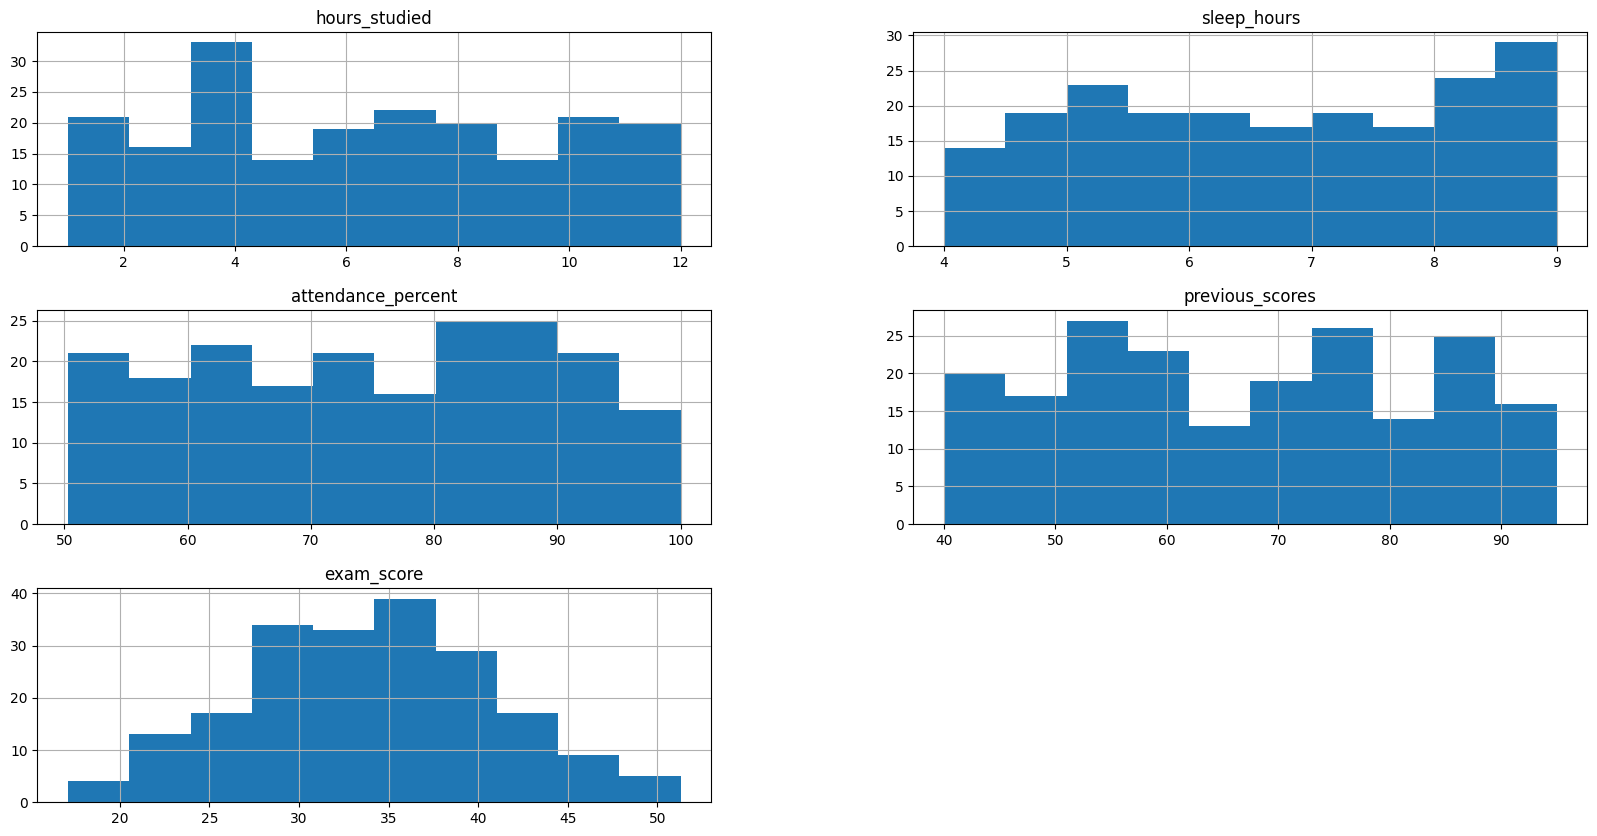

In [ ]:
df.hist(figsize=(20,10))

# Data Cleaning

## Drop Duplicate

In [ ]:
df = df.drop_duplicates()

## Remove Outliers

In [ ]:
df.describe()

,hours_studied,sleep_hours,attendance_percent,previous_scores,exam_score
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,6.325500,6.622000,74.830000,66.800000,33.955000
std,3.227317,1.497138,14.249905,15.663869,6.789548
min,1.000000,4.000000,50.300000,40.000000,17.100000
25%,3.500000,5.300000,62.200000,54.000000,29.500000
50%,6.150000,6.700000,75.250000,67.500000,34.050000
75%,9.000000,8.025000,87.425000,80.000000,38.750000
max,12.000000,9.000000,100.000000,95.000000,51.300000


***Note***: Data seems to not have any outlier, and this data is "nearly" normal distributed since the mean of all features are very closed to the average.

## Normalized Data

The only non-numerical feature is Student ID, which we might not want to use for our training process. All other features are numerical, so we do not need to normalize anything.

# Data Validation

<Axes: >

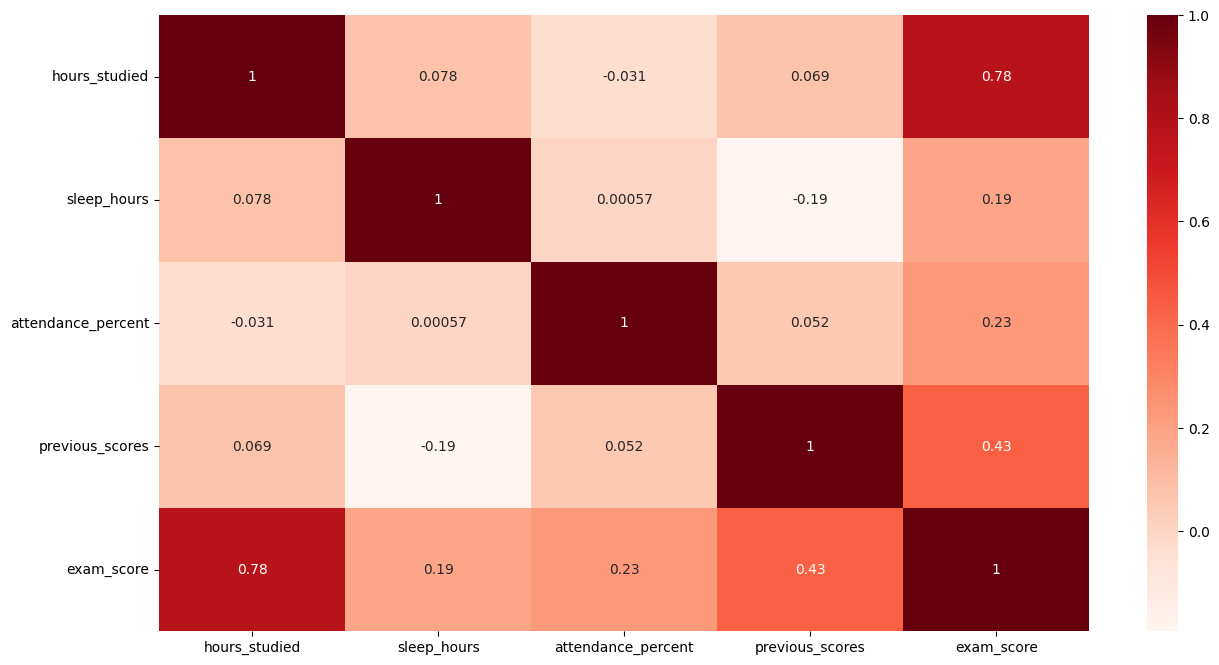

In [ ]:
df_corr = df.corr(method='pearson', numeric_only=True)
plt.figure(figsize=(15,8))
sns.heatmap(
    df_corr,
    cmap = 'Reds',
    annot=True
)

***Finding***: We can tell the two features that have the highest correlation with exam_score is **hours_studied**, and **previous_scores**

But since we only have 4 features in the dataset, it might be better to create new features that might have the high correlation.

Unlike health_and_life_style dataset, there is not scientific formula for that related to the features we have, we might just come up with something that makes sense in "someway"

-> regular_activity_hours = 24 - (sleep hours+study_hour). We can test it out before actually use it in our df

In [ ]:
test = df.copy()

test['regular_activity_hours'] = 24- (test['sleep_hours'] + test['hours_studied'])
test

,student_id,hours_studied,sleep_hours,attendance_percent,previous_scores,exam_score,regular_activity_hours
0,S001,8.0,8.8,72.1,45,30.2,7.2
1,S002,1.3,8.6,60.7,55,25.0,14.1
2,S003,4.0,8.2,73.7,86,35.8,11.8
3,S004,3.5,4.8,95.1,66,34.0,15.7
4,S005,9.1,6.4,89.8,71,40.3,8.5
...,...,...,...,...,...,...,...
195,S196,10.5,5.4,94.0,87,42.7,8.1
196,S197,7.1,6.1,85.1,92,40.4,10.8
197,S198,1.6,6.9,63.8,76,28.2,15.5
198,S199,12.0,7.3,50.5,58,42.0,4.7


<Axes: >

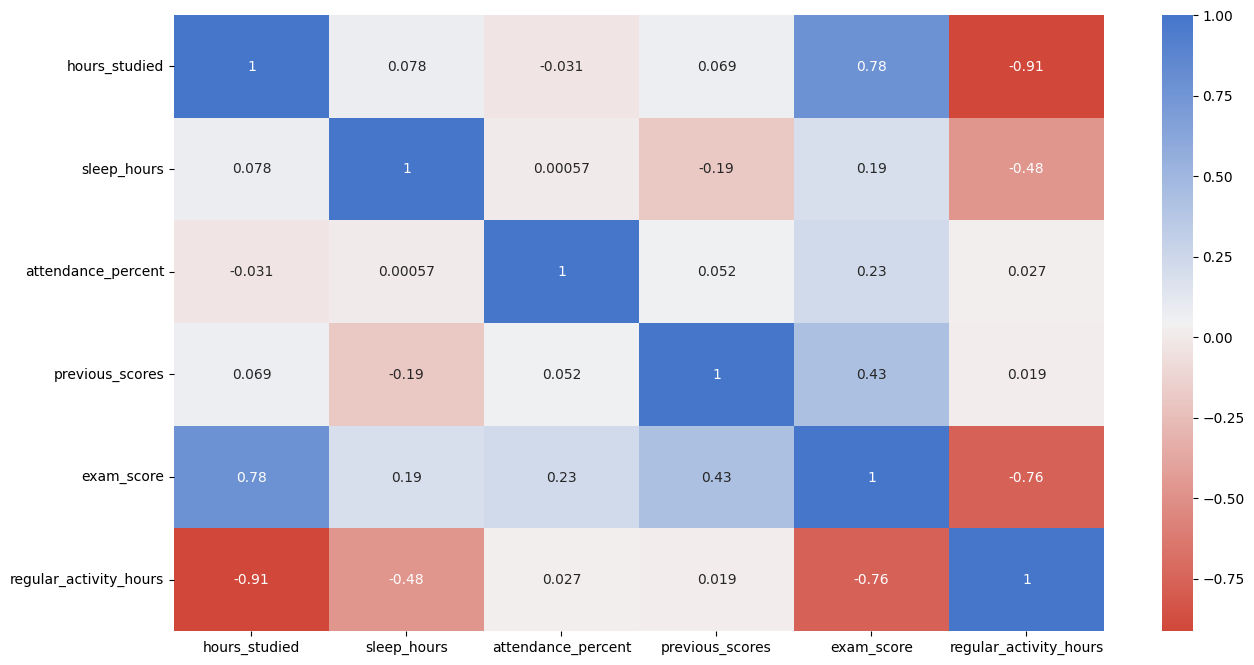

In [ ]:
test_corr = test.corr(numeric_only=True)

plt.figure(figsize=(15,8))
sns.heatmap(
    test_corr,
    cmap=sns.diverging_palette(15, 255, as_cmap=True),
    annot= True
)

***Finding***: Our new feature, regular_activity_hours have a very strong correlation (oppositely) with exam_score. If that is the case, I think I might keep it. Also, another reason why I am keeping it is that it does seem to be a brand new features feature as it is calculated from a new information, 24 hour.

In [ ]:
df['regular_activity_hours'] = 24- (df['sleep_hours'] + df['hours_studied'])

# Data Spitting

Before splitting the data, we might want to check all our columns and decide what to drop. Our dataset includes:
- student_id
- hours_studied
- sleep_hours
- attendance_percent
- previous_score
- regular_activity_hours
- exam_score (labels)

We will definitely drop the student_id. Since the number of columns are very small (5), then I think we should not drop less corr columns, since it might save our model from overfitting.

In [ ]:
df.drop(columns='student_id', inplace = True)

In [ ]:
df

,hours_studied,sleep_hours,attendance_percent,previous_scores,exam_score,regular_activity_hours
0,8.0,8.8,72.1,45,30.2,7.2
1,1.3,8.6,60.7,55,25.0,14.1
2,4.0,8.2,73.7,86,35.8,11.8
3,3.5,4.8,95.1,66,34.0,15.7
4,9.1,6.4,89.8,71,40.3,8.5
...,...,...,...,...,...,...
195,10.5,5.4,94.0,87,42.7,8.1
196,7.1,6.1,85.1,92,40.4,10.8
197,1.6,6.9,63.8,76,28.2,15.5
198,12.0,7.3,50.5,58,42.0,4.7


In [ ]:
X = df.drop(columns='exam_score')
y = df['exam_score']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state=42
)

## Data Preprocessing

Since our dataset is very simple, with only numerical variables

In [ ]:
num_col = ['hours_studied', 'sleep_hours', 'attendance_percent', 'previous_scores','regular_activity_hours']

In [ ]:
preprocessing = make_column_transformer(
    (MinMaxScaler(), num_col),
    remainder = 'drop'
)

preprocessing.fit(X_train)

X_train_final = preprocessing.transform(X_train)
X_test_final = preprocessing.transform(X_test)

# Model Training

In [ ]:
model = models.Sequential([
    layers.Input(shape = (X_train_final.shape[1],)),
    layers.Dense(8, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(1)
])

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'mse',
    metrics = [tf.keras.metrics.MeanAbsoluteError(name='mae'),
        tf.keras.metrics.RootMeanSquaredError(name='rmse')] # Corrected 'rmse' to 'RootMeanSquaredError'
)

In [ ]:
cbs = [
    callbacks.EarlyStopping(
        monitor='val_rmse',
        mode='min',
        patience=20,
        min_delta=0.05,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_rmse',
        mode='min',
        factor=0.5,
        patience=5,
        cooldown=2,
        min_lr=1e-6,
        verbose=1
    )
]

In [ ]:
history = model.fit(
    X_train_final,
    y_train,
    validation_split=0.1,
    epochs = 700,
    batch_size = 8,
    callbacks= cbs,
    verbose =1
)

test_mse, test_mae, test_rmse = model.evaluate(X_test_final, y_test, verbose=1)
print(f"Test MAE:  {test_mae:.2f} points")
print(f"Test RMSE: {test_rmse:.2f} points")
print(f"Test R2:   {r2_score(y_test, model.predict(X_test_final, verbose=0)):.3f}")

Epoch 1/700
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1156.1371 - mae: 33.2614 - rmse: 33.9930 - val_loss: 1280.9502 - val_mae: 35.0518 - val_rmse: 35.7904 - learning_rate: 0.0010
Epoch 2/700
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1184.6949 - mae: 33.8002 - rmse: 34.4171 - val_loss: 1269.3429 - val_mae: 34.8864 - val_rmse: 35.6278 - learning_rate: 0.0010
Epoch 3/700
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1167.2001 - mae: 33.5726 - rmse: 34.1611 - val_loss: 1257.7113 - val_mae: 34.7207 - val_rmse: 35.4642 - learning_rate: 0.0010
Epoch 4/700
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1125.2816 - mae: 32.8934 - rmse: 33.5438 - val_loss: 1245.4333 - val_mae: 34.5455 - val_rmse: 35.2907 - learning_rate: 0.0010
Epoch 5/700
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1127.2673 - mae: 32.8881 - rmse: 33.5730 - val_loss: 1232.3920 - val_mae: 34.3588 - val_rmse: 35.1054 - learning_rate: 0.0010
Epoch 6/700
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1196.4937 - mae